In [30]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [32]:
class Generator(nn.Module) :
    def __init__(self, z_dim=20, image_size=64) :
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(z_dim, image_size*8,
                                                      kernel_size=4, stride=1),
                                   nn.BatchNorm2d(image_size*8),
                                   nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(image_size*8,
                                                      image_size*4,
                                                      kernel_size=4,
                                                      stride=2,
                                                      padding=1),
                                   nn.BatchNorm2d(image_size*4),
                                   nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(image_size*4,
                                                       image_size*2,
                                                       kernel_size=4,
                                                       stride=2,
                                                       padding=1),
                                   nn.BatchNorm2d(image_size*2),
                                   nn.ReLU(inplace=True))
        
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(image_size*2,
                                                      image_size,
                                                      kernel_size=4,
                                                      stride=2,
                                                      padding=1),
                                   nn.BatchNorm2d(image_size),
                                   nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(nn.ConvTranspose2d(image_size, 1, 
                                                    kernel_size=4,
                                                    stride=2,
                                                    padding=1),
                                 nn.Tanh())
        
        # 흑백 화상이므로 출력 채널은 하나
        
    def forward(self, z) :
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)        
        out = self.layer4(out)
        out = self.last(out)
        
        return out

In [33]:
class Discriminator(nn.Module) :
    
    def __init__(self, z_dim=20, image_size=64) :
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(nn.Conv2d(1, image_size,
                                             kernel_size=4, stride=2,
                                             padding=1),
                                   nn.LeakyReLU(0.1, inplace=True))
        # 흑백 화상이므로 입력 채널은 하나
        
        self.layer2 = nn.Sequential(nn.Conv2d(image_size, image_size*2,
                                             kernel_size=4, stride=2,
                                             padding=1),
                                   nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(nn.Conv2d(image_size*2, image_size*4,
                                             kernel_size=4, stride=2,
                                             padding=1),
                                   nn.LeakyReLU(0.1, inplace=True))
        
        self.layer4 = nn.Sequential(nn.Conv2d(image_size*4, image_size*8,
                                             kernel_size=4, stride=2,
                                             padding=1),
                                   nn.LeakyReLU(0.1, inplace=True))
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x) :
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        feature = out
        feature = feature.view(feature.size()[0], -1) # 2차원으로 변환
        
        out = self.last(out)
        
        return out, feature
        

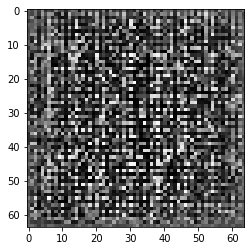

In [47]:
# 구현한 G로 화상을 생성하기

# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 난수 입력
input_z = torch.randn(1, 20)

# 텐서 크기 (1, 20, 1, 1)로 변형
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 가짜 화상 출력
fake_images= G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [35]:
# G에서 가짜 화상을 생성한 후 D에 입력하여 판단 
# (G에서 생성된 가짜 화상이면 라벨 0, 지도 데이터면 라벨 1)
# 동작 확인
D = Discriminator(z_dim=20, image_size=64)

# 가짜 화상 생성
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 가짜 화상을 D에 입력
d_out = D(fake_images)

# 출력 d_out에 시그모이드를 곱하여 0에서 1로 변환
print(nn.Sigmoid()(d_out[0]))

print(d_out[1].shape)

tensor([[[[0.5032]]]], grad_fn=<SigmoidBackward>)
torch.Size([1, 8192])


In [31]:
# 데이터 로더 준비
def make_datapath_list() :
    '''학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트 작성'''
    
    train_img_list = list() # 화상 파일 경로 저장
    
    for img_idx in range(200) :
        img_path = './pytorch_advanced/gan_anomaly_detection/data/img_78/img_7_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './pytorch_advanced/gan_anomaly_detection/data/img_78/img_8_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

class ImageTransform() :
    '''화상 전처리 클래스'''
    
    def __init__(self, mean, std) :
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])
    def __call__(self, img) :
        return self.data_transform(img)
    
class GAN_Img_Dataset(data.Dataset) :
    '''화상의 데이터셋 클래스, 파이토치의 데이터셋 클래스를 상속'''
    
    def __init__(self, file_list, transform) :
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self) :
        '''화상 매수 반환'''
        return len(self.file_list)
    
    def __getitem__(self, index) :
        '''전처리 화상의 텐서 형식 데이터 취득'''
        
        img_path = self.file_list[index]
        img = Image.open(img_path) # [높이][폭]
        
        # 화상 전처리
        img_transformed = self.transform(img)
        
        return img_transformed
    
    # 데이터 로더 작성과 동작 확인

    
# 파일 리스트 작성
train_img_list = make_datapath_list()

# 데이터셋 작성
mean = (0.5, )
std = (0.5, )

train_dataset = GAN_Img_Dataset(file_list=train_img_list,
                               transform=ImageTransform(mean, std))

# 데이터 로더 작성
batch_size=  64

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
# 동작 확인
batch_iterator = iter(train_dataloader) # 반복자로 변환
images = next(batch_iterator) # 첫 번째 요소를 꺼냄
print(images.size()) # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 64, 64])


---
DCGAN의 네트워크 및 학습법 사용

In [28]:
# 네트워크 초기화
# --> 전치합성곱과 합성곱 층의 가중치는 평균 0, 표준편차 0.02의 정규 분포로,
# 배치 정규화의 가중치는 평균 1, 표준편차 0.02의 정규 분포를 따르도록 초기화
# 각 바이어스 항은 초기는 0으로 함.
def weights_init(m) : 
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 :
        # Conv2d와 ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    
    elif classname.find('BatchNorm') != -1 :
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)

print('네트워크 초기화 완료!')

네트워크 초기화 완료!


### AnoGAN의 생성 난수 z를 구하는 방법
- 적당한 노이즈 z를 난수로 구하여 노이즈 z로 화상을 생성.
생성된 화상과 테스트 화상의 채널별 픽셀 수준의 차이를 계산한 후, 픽셀 차이의 절댓값 합을 구하여 손실 값을 계산.
채널별 픽셀 수준의 차이를 줄이려면 z의 각 차원에서 값을 크게 할지 혹은 작게 할지,
즉 손실 값에 대한 z의 미분 값을 구함.

- 미분 값에 따라 z를 갱신하면 갱신된 z는 이전보다 테스트 화상과 더 비슷한 화상을 생성할 수 있음.
이 단계를 반복하여 테스트 화상과 유사한 화상을 만들 수 있는 입력 노이즈 z가 구해짐.

In [59]:
# 모델을 학습시키는 함수 작성


def train_model(G, D, dataloader, num_epochs):

    # GPU를 사용할 수 있는지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

     # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 오차 함수 정의
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # # 파라미터
    z_dim = 20
    mini_batch_size = 64

     # 네트워크를 GPU로
    G.to(device)
    D.to(device)

    # 모델을 훈련 모드로
    G.train()  
    D.train() 

   # 네트워크가 어느정도 고정되면 고속화
    torch.backends.cudnn.benchmark = True

    # 화상 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # 에폭 루프
    for epoch in range(num_epochs):

         # 개시 시간 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # 에폭의 손실 합
        epoch_d_loss = 0.0  # 에폭의 손실 합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

         # 데이터 로더에서 미니 배치씩 꺼내는 루프
        for imges in dataloader:

            # -----------------------
            # 1. Discriminator 학습
            # -----------------------
            # 미니 배치 크기가 1이면 배치 정규화해서 오류가 발생하므로 피함
            if imges.size()[0] == 1:
                continue

                # GPU를 사용할 수 있다면 GPU로 데이터를 보냄
            imges = imges.to(device)

            # 정답 라벨과 가짜 라벨 작성
            # 에폭의 마지막 반복은 미니배치 수가 줄어듦
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

             # 진짜 화상 판정
            d_out_real, _ = D(imges)

            # 가짜 화상을 생성하여 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

             # 오차 계산
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # -----------------------
            # 2. Generator 학습
            # -----------------------
            # 가짜 화상을 생성하여 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 역전파
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # 오차 계산
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            
            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # 에폭의 phase별 손실과 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    
    print("総イテレーション回数:", iteration)

    return G, D


num_epochs = 300
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


使用デバイス： cpu
-------------
Epoch 0/300
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.0448 ||Epoch_G_Loss:7.3742
timer:  30.9089 sec.
-------------
Epoch 1/300
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0020 ||Epoch_G_Loss:6.0323
timer:  17.1820 sec.
-------------
Epoch 2/300
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:2.5053
timer:  13.3054 sec.
-------------
Epoch 3/300
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:2.0006
timer:  13.3543 sec.
-------------
Epoch 4/300
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:1.3947
timer:  13.4022 sec.
-------------
Epoch 5/300
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:1.4908
timer:  13.2755 sec.
-------------
Epoch 6/300
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:1.2000
timer:  13.3074 sec.
-------------
Epoch 7/300
----------

-------------
epoch 60 || Epoch_D_Loss:0.0933 ||Epoch_G_Loss:0.9387
timer:  13.1219 sec.
-------------
Epoch 61/300
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:0.0105 ||Epoch_G_Loss:0.6207
timer:  13.1119 sec.
-------------
Epoch 62/300
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:0.0409 ||Epoch_G_Loss:0.7203
timer:  13.1608 sec.
-------------
Epoch 63/300
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:0.0139 ||Epoch_G_Loss:0.5906
timer:  13.1867 sec.
-------------
Epoch 64/300
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:0.0425 ||Epoch_G_Loss:0.7191
timer:  13.1967 sec.
-------------
Epoch 65/300
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:0.0728 ||Epoch_G_Loss:0.6388
timer:  13.1498 sec.
-------------
Epoch 66/300
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:0.0466 ||Epoch_G_Loss:0.5655
timer:  13.0950 sec.
-------------
Epoch 67/300
-------------
（train）
-------------
epoch 67 || Epoch_D_

-------------
epoch 120 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.2574
timer:  13.1309 sec.
-------------
Epoch 121/300
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:0.0655 ||Epoch_G_Loss:0.2408
timer:  13.0172 sec.
-------------
Epoch 122/300
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.2695
timer:  13.0960 sec.
-------------
Epoch 123/300
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:0.0453 ||Epoch_G_Loss:0.3016
timer:  13.1409 sec.
-------------
Epoch 124/300
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:0.0650 ||Epoch_G_Loss:0.2322
timer:  13.1059 sec.
-------------
Epoch 125/300
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:0.0602 ||Epoch_G_Loss:0.2626
timer:  13.0960 sec.
-------------
Epoch 126/300
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:0.0576 ||Epoch_G_Loss:0.2936
timer:  13.0671 sec.
-------------
Epoch 127/300
-------------
（train）
-------------
epoch 

-------------
epoch 179 || Epoch_D_Loss:0.0460 ||Epoch_G_Loss:0.4249
timer:  13.1758 sec.
-------------
Epoch 180/300
-------------
（train）
-------------
epoch 180 || Epoch_D_Loss:0.0292 ||Epoch_G_Loss:0.3932
timer:  13.1329 sec.
-------------
Epoch 181/300
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:0.0328 ||Epoch_G_Loss:0.4055
timer:  13.1468 sec.
-------------
Epoch 182/300
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:0.0198 ||Epoch_G_Loss:0.4716
timer:  13.1877 sec.
-------------
Epoch 183/300
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:0.0413 ||Epoch_G_Loss:0.3933
timer:  13.1558 sec.
-------------
Epoch 184/300
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:0.0244 ||Epoch_G_Loss:0.5170
timer:  13.4301 sec.
-------------
Epoch 185/300
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:0.0226 ||Epoch_G_Loss:0.3749
timer:  13.8472 sec.
-------------
Epoch 186/300
-------------
（train）
-------------
epoch 

-------------
epoch 238 || Epoch_D_Loss:0.0151 ||Epoch_G_Loss:0.5438
timer:  13.8102 sec.
-------------
Epoch 239/300
-------------
（train）
-------------
epoch 239 || Epoch_D_Loss:0.0044 ||Epoch_G_Loss:0.6751
timer:  13.8236 sec.
-------------
Epoch 240/300
-------------
（train）
-------------
epoch 240 || Epoch_D_Loss:0.0357 ||Epoch_G_Loss:0.4480
timer:  13.7663 sec.
-------------
Epoch 241/300
-------------
（train）
-------------
epoch 241 || Epoch_D_Loss:0.0204 ||Epoch_G_Loss:0.5535
timer:  13.8488 sec.
-------------
Epoch 242/300
-------------
（train）
-------------
epoch 242 || Epoch_D_Loss:0.0082 ||Epoch_G_Loss:0.5649
timer:  13.7782 sec.
-------------
Epoch 243/300
-------------
（train）
-------------
epoch 243 || Epoch_D_Loss:0.0042 ||Epoch_G_Loss:0.6276
timer:  13.7192 sec.
-------------
Epoch 244/300
-------------
（train）
-------------
epoch 244 || Epoch_D_Loss:0.0045 ||Epoch_G_Loss:0.6402
timer:  13.7236 sec.
-------------
Epoch 245/300
-------------
（train）
-------------
epoch 

-------------
epoch 297 || Epoch_D_Loss:0.0093 ||Epoch_G_Loss:0.6941
timer:  14.0668 sec.
-------------
Epoch 298/300
-------------
（train）
-------------
epoch 298 || Epoch_D_Loss:0.0489 ||Epoch_G_Loss:0.6052
timer:  13.9325 sec.
-------------
Epoch 299/300
-------------
（train）
-------------
epoch 299 || Epoch_D_Loss:0.0031 ||Epoch_G_Loss:0.6478
timer:  13.9199 sec.
総イテレーション回数: 2101


In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

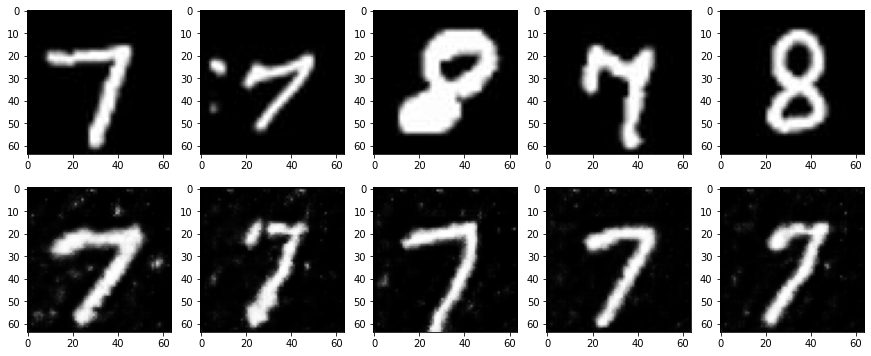

In [60]:
batch_size= 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)
fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5) :
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

## AnoGAN의 손실함수 
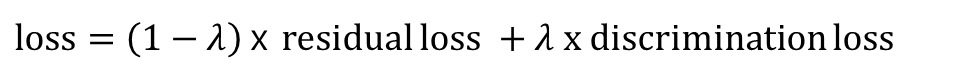

In [61]:
def Anomaly_score(x, fake_img, D, Lambda=0.1) :
    
    # 테스트 화상 x와 생성 화상 fake_img의 픽셀 수준 차이의 절댓값을 계산하여
    # 미니 배치마다 합을 구함
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    
    # 테스트 화상 x와 생성 화상 fake_img를 식별기 D에 입력하여 특징량 맵을 꺼냄
    _, x_feature = D(x)
    _, G_feature = D(fake_img)
    
    # 테스트 화상 x와 생성 화상 fake_img의 특징량 차이의 절댓값을 계산하여
    # 미니 배치마다 합을 구함
    discrimination_loss = torch.abs(x_feature-G_feature)
#     discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
    # 미니 배치마다 두 종류의 손실을 더함
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    # 모든 미니 배치의 손실을 구함
    total_loss = torch.sum(loss_each)
    
    return total_loss, loss_each, residual_loss

## AnoGAN 학습 구현과 이상 탐지 

In [62]:
# 테스트용 데이터로더 작성

def make_test_datapath_list() :
    '''학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트 작성'''
    
    train_img_list = list() # 화상 파일 경로 저장
    
    for img_idx in range(5) :
        img_path = './pytorch_advanced/gan_anomaly_detection/data/test/img_7_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './pytorch_advanced/gan_anomaly_detection/data/test/img_8_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './pytorch_advanced/gan_anomaly_detection/data/test/img_2_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

# 파일 리스트 작성
test_img_list = make_test_datapath_list()

# 데이터셋 작성
mean = (0.5, )
std = (0.5, )
test_dataset = GAN_Img_Dataset(file_list=test_img_list, 
                              transform=ImageTransform(mean, std))

# 데이터 로더 작성
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=batch_size,
                                             shuffle=False)

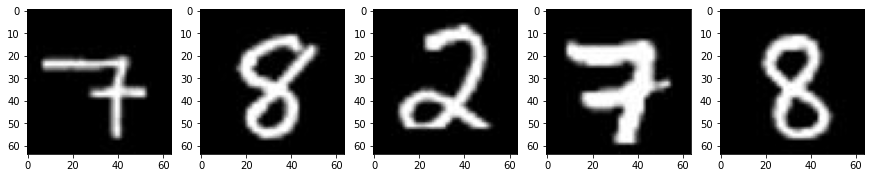

In [63]:
# 테스트 데이터 확인
batch_iterator = iter(test_dataloader) # 반복자로 변환
images = next(batch_iterator)

# 첫 번째 미니배치를 꺼냄
fig = plt.figure(figsize=(15, 6))

for i in range(0, 5) :
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')

In [64]:
# 이상 탐지 화상
x = images[0:5]
x = x.to(device)

# 이상 탐지할 화상을 생성하기 위한 초기 난수
z = torch.randn(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

# 변수 z를 미분할 수 있도록 requires_grad를 True로 
z.requires_grad = True

# 변수 z를 갱신할 수 있도록 z의 최적화 함수를 구한다
z_optimizer = torch.optim.Adam([z], lr=1e-3)


# z를 구한다
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))


epoch 0 || loss_total:8268 
epoch 1000 || loss_total:6957 
epoch 2000 || loss_total:6611 
epoch 3000 || loss_total:6405 
epoch 4000 || loss_total:6127 
epoch 5000 || loss_total:6083 


total loss : [ 790. 1444. 1549.  865. 1436.]


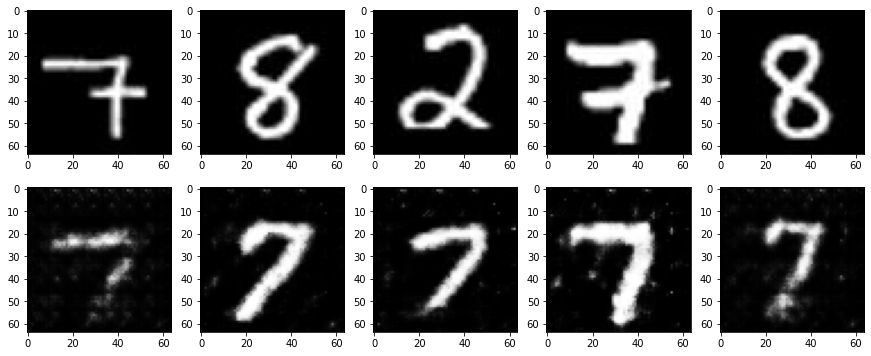

In [65]:
# 화상 생성
G_update.eval()
fake_img = G_update(z)

# 손실을 구함
loss, loss_each, residual_loss_each = Anomaly_score(x, fake_img,
                                                   D_update, Lambda=0.1)

# 총 계산, 총 손실
loss_each = loss_each.cpu().detach().numpy()
print('total loss :', np.round(loss_each, 0))

# 화상의 시각화
fig = plt.figure(figsize=(15, 6))

for i in range(0, 5) :
    # 상단에 테스트 데이터 표시
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 하단에 생성 데이터 표시
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')